# Gromov Approximating Trees

The following is an implementation of the algorithm discussed in [Gromov's Approximating Tree and the All-Pairs Bottleneck Paths Problem](https://arxiv.org/abs/2408.05338) by Anders Cornect (myself) and Dr. Eduardo Martinez-Pedroza of Memorial University of Newfoundland.

Given a NetworkX graph, this code returns its Gromov's Approximating Tree (also as a NetworkX graph). There is also an example, along with some further detail about its use, at the end of the notebook.

# Initialization & Imports

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta
import time

## Generating Random Graphs

The following are two functions that generate random connected graphs (weighted or unweighted).

In [3]:
#####
# Repeatedly generates Erdos-Renyi graphs G(n,p) until
# the result is a connected graph.
def Connected_ER(n, p):
  G = nx.erdos_renyi_graph(n,p)
  while not nx.is_connected(G):
    G = nx.erdos_renyi_graph(n,p)
  return G

#####
# Generates a connected, random Erdos-Renyi graph
# G(n,p), with uniformly random integer weights from
# the interval [min_weight, max_weight] on the edges.
def Connected_Weighted_ER(n, p, min_weight=1, max_weight=1):
  G = Connected_ER(n,p)
  for (u,v,w) in G.edges(data=True):
    w['weight'] = random.randint(min_weight,max_weight)
  return G

# Solving the APBP Problem

The following function takes a tree T, and returns a solution matrix to
the [All-Pairs Bottleneck Paths](https://en.wikipedia.org/wiki/Widest_path_problem) problem (also known as the all-pairs "widest path" or "maximum capacity path" problem) on T. We will explain where we use it below.

In [4]:
#####
# Given a tree T, solves the All-Pairs Bottleneck Paths problem
# on T using a modified breadth-first search algorithm.
def BFS_APBP(T):

  n = T.number_of_nodes()

  APBP = np.ones((n,n)) * np.inf
  for i in range(n):
    APBP[i][i] = 0

  for i in range(n):
    visited = []
    to_visit = [(i, np.inf)]

    while to_visit != []:
      node, width = to_visit.pop(0)
      visited.append(node)

      for neighbor in T[node]:
        if neighbor not in visited:
          new_width = float(min(width, T[node][neighbor]['weight']))
          to_visit.append((neighbor, new_width))
          APBP[i][neighbor] = new_width

  return APBP

## Generating Approximating Trees

## Gromov_TrX_Metric

Gromov\_TrX\_Metric is the central function in this notebook. Given a graph $G$ and a vertex $w$ of $G$, $\texttt{Gromov_TrX_Metric}(G,w)$ returns the Gromov approximating tree of $G$ at $w$, as a NetworkX graph.

Note that this procedure is exactly as described in our paper - we create the complete graph of Gromov products, solve the APBP problem on this graph (by finding a maximal spanning tree and using a modified BFS algorithm), then use the result to calculate the Gromov distance between each pair of vertices.

In [5]:
#####
# Given the distance matrix D of a graph G and a vertex (index) w,
# calculates Gromov's approximating tree for G based at w.

def Gromov_TrX_Metric(G, w = 0, print_stats = False):

  n = G.number_of_nodes()

  # Get the distance matrix of the graph G
  # (in our case, dist_G is actually a dictionary)
  dist_G = nx.floyd_warshall_numpy(G)

  # Turn dist_G into a complete graph, where the weight of
  # edge (u_i,u_j) is -(u_i|u_j)_w, i.e. the negative of
  # the Gromov product of the ith and jth vertices of G.
  K_G = nx.complete_graph(n)
  for i, j, d in K_G.edges(data=True):

    # The reason we use the negative, is that NetworkX only has a
    # minimum spanning tree function, but we need a maximum
    # spanning tree.
    d['weight'] = -1 * (dist_G[i][w] + dist_G[j][w] - dist_G[i][j]) / 2

  # Find maximum spanning tree of K_G, takes O(n^2) time
  prod_tree = nx.minimum_spanning_tree(K_G)
  for i, j, d in prod_tree.edges(data=True):
    d['weight'] = -1 * d['weight']

  # Solve APBP on the spanning tree instead, takes O(n^2) time
  prime_prod = BFS_APBP(prod_tree)
  dist_T = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      dist_T[i][j] = float(dist_G[i][w] + dist_G[j][w] - 2*prime_prod[i][j])

  # Nothing below is strictly necessary, as we already have the distances, but
  # making it into an actual tree is nice.
  T = nx.Graph()
  T.add_nodes_from(range(n))
  for i in range(n):
    for j in range(i+1,n):
      # Connect distance-1 and distance-0 nodes
      if dist_T[i][j] in [0.0, 1.0]:
        T.add_edge(i, j, weight = dist_T[i][j])

  # Optional: Print the average and maximum difference between the
  # distances in G and T.
  if print_stats:
    diffs = []
    for i in range(n-1):
      for j in range(i+1, n):
        # No absolute value necessary since T is non-increasing.
        diffs.append(dist_G[i][j] - dist_T[i][j])

    print(diffs)

    print(f"Average Change in Distance: {np.mean(diffs)}")
    print(f"Maximum Change in Distance: {max(diffs)}")

  # Take all clusters of distance-0 nodes and identify them
  merged = False
  new_names = {i:str(i) for i in range(n)}
  while not merged:
    cont = False
    for i, j, d in T.edges(data=True):
      if d['weight'] == 0.0:
        nx.identified_nodes(T, i, j, self_loops=False, copy=False)
        new_names[i] = new_names[i] + ', ' + str(j)
        # Once a distance-0 pair has been found, restart the search
        # with the modified edge list. Stop once every edge has been
        # visited with no weight-0 distances found.
        cont = True
        break
    if cont:
      continue
    merged = True

  nx.relabel_nodes(T, new_names, copy=False)
  return T

# Given a graph G and a vertex w of G, returns the Gromov approximating
# tree of G based at w, and also draws them.

def Generate_Draw_TrX(G, w = 0):

  start_time = time.time()
  D = nx.floyd_warshall_numpy(G)
  end_time = time.time()
  print("Graph distances generated in", timedelta(seconds = end_time - start_time))

  dist_G = nx.floyd_warshall_numpy(G)
  plt.figure(0)
  start_time = time.time()
  T = Gromov_TrX_Metric(G, w)
  end_time = time.time()
  print("Gromov tree distances generated in", timedelta(seconds = end_time - start_time))

  plt.figure(1)
  pos_G = nx.bfs_layout(G, w)
  nx.draw(G, pos_G, with_labels = True)
  plt.figure(2)
  pos_T = nx.bfs_layout(T, str(w))
  nx.draw(T, pos_T, with_labels = True)

  return T

# An Example

Below is an example that was (originally) randomly generated. The top figure is
the graph $G$, and below is the tree $T$ (based at $w$ = 0). You may be wondering why $T$ isn't actually a tree - this is because Gromov's approximating tree is only guaranteed to be a $\mathit{0}$*-hyperbolic* space. It will not necessarily be an unweighted tree. However, we *can* turn it into a *weighted* tree, which we do below.

Graph distances generated in 0:00:00.004051
Gromov tree distances generated in 0:00:00.005721


<Figure size 640x480 with 0 Axes>

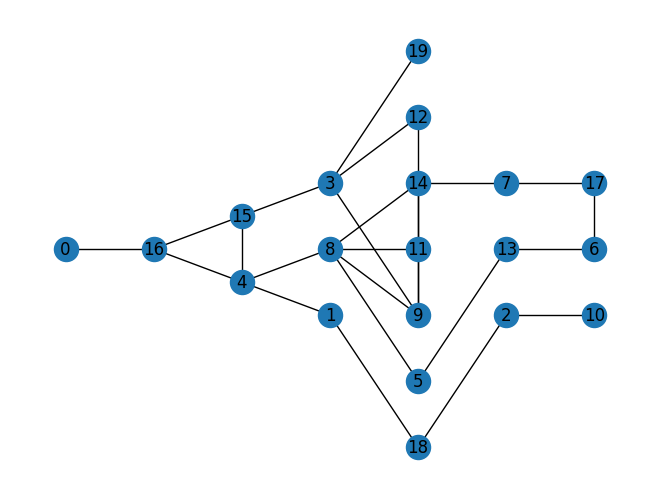

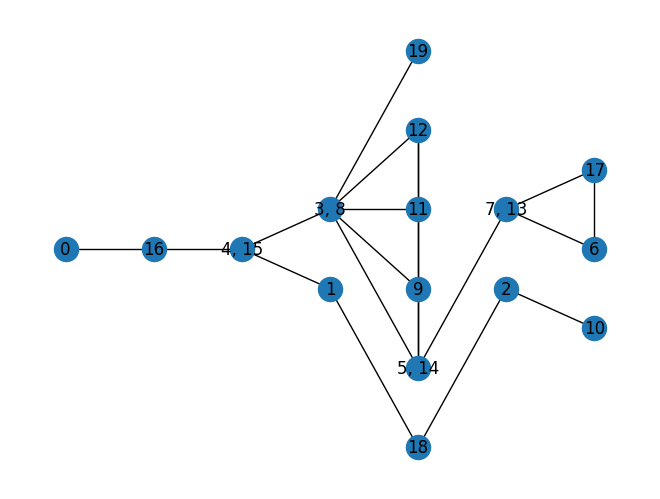

In [6]:
G = nx.Graph()
G.add_nodes_from(range(20))
G.add_edges_from([
    (0, 16), (1, 4), (1, 18), (2, 10),
    (2, 18), (3, 9), (3, 12), (3, 15),
    (3, 19), (4, 8), (4, 15), (4, 16),
    (5, 8), (5, 13), (6, 13), (6, 17),
    (7, 14), (7, 17), (8, 9), (8, 11),
    (8, 14), (9, 12), (9, 14), (15, 16)
])
w = 0
T = Generate_Draw_TrX(G, w)

Since it is a $0$-hyperbolic space, it will be a chordal graph, i.e. the only "non-tree" portions are cliques. Therefore, we can take each clique that appears in the graph, remove all of the edges within it, and add a "ghost node", connecting each of the vertices in the clique to it with a weighted edge of weight $1/2$. The reason we prefer to distinguish it as a "ghost node" is because it does not represent any vertex in $G$, but this doesn't matter so much.

We only do this with our one example instead of adding a function to do it with general examples because it is unnecessary but frankly it also seems quite time consuming, and would require a lot of extra work...

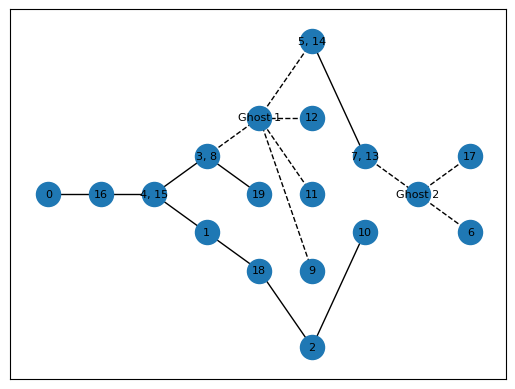

In [7]:
T_fixed = T.copy()
T.add_nodes_from(['Ghost 1', 'Ghost 2'])
clique_1 = ['3, 8', '9', '11', '12', '5, 14']
clique_2 = ['7, 13', '6', '17']
for node in clique_1:
  T_fixed.add_edge(node, 'Ghost 1', weight=0.5)
  for other in clique_1:
    if T_fixed.has_edge(node, other):
      T_fixed.remove_edge(node, other)
for node in clique_2:
  T_fixed.add_edge(node, 'Ghost 2', weight=0.5)
  for other in clique_2:
    if T_fixed.has_edge(node, other):
      T_fixed.remove_edge(node, other)
    if T_fixed.has_edge(other, node):
      T_fixed.remove_edge(other, node)

pos_T_fixed = nx.bfs_layout(T_fixed, str(w))
nx.draw_networkx_nodes(T_fixed, pos_T_fixed)
nx.draw_networkx_labels(T_fixed, pos_T_fixed, font_size=8)

ghost_edges = []
full_edges = []
for edge in T_fixed.edges(data=True):
  if edge[2]['weight'] == 0.5:
    ghost_edges.append(edge)
  else:
    full_edges.append(edge)

nx.draw_networkx_edges(T_fixed, pos_T_fixed, edgelist=ghost_edges, style='dashed')
nx.draw_networkx_edges(T_fixed, pos_T_fixed, edgelist=full_edges)